Heston’s stochastic volatility model:
$$
\frac{dS_t}{S_t} = (r − q)dt + \sqrt{v_t} dW_t , \quad S_0 \geq 0
$$
$$
dv_t = \kappa(\eta − v_t)dt + \theta \sqrt{v_t} d\tilde{W}_t , \quad v_0 = \sigma^2_0 \geq 0
$$
where \(W_t\) and \(\tilde{W}_t\) are correlated Brownian motions (correlation \(\rho\)).

Parameters:
- Speed/rate of mean reversion: (kappa > 0)
- Level of mean reversion: (eta > 0)
- Vol-of-vol: (theta > 0)
- Initial variance: (v_0 > 0)
- Correlation vol-stock: (-1 < rho < 1)

In [6]:
#imports
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import math

In [7]:
# Hetson variables !!eta 
V0 = 0.05
kappa = 0.5 
eta = 0.05
theta = 0.2
rho = -0.75

In [8]:
# Heston characteristic function

def cf_Heston(u, S0, r, q, V0, kappa, eta, theta, rho, T):
    i = complex(0, 1)
    d = np.sqrt((rho * theta * u * i - kappa)**2 - (theta**2) * (-i * u - u**2))
    g = (kappa - rho * theta * u * i - d) / (kappa - rho * theta * u * i + d)
    
    term1 = i * u * (np.log(S0) + (r - q) * T)
    term2 = (eta * kappa / theta**2) * ((kappa - rho * theta * u * i - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    term3 = (V0 / theta**2) * (kappa - rho * theta * u * i - d) * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
    
    return np.exp(term1 + term2 + term3)

In [9]:
# test cf_heston (1,1) = -0-0879 - 0.9699j
result = cf_Heston(1, 100, 0.05, 0, V0, kappa, eta, theta, rho, 1)
print (result)

(-0.07824684212425079-0.9706940353985339j)


In [10]:
# Market data
S0 = 100
q = 0.01
r = 0.05
sigma = 0.25
K = [90, 95, 100, 105, 110]
T = 3/12

In [11]:
# variables for FFT pricing (eta != eta_cm)
eta_cm = 0.25
N = 4096
alpha = 1.5
lambda_ = (2 * math.pi) / (N* eta_cm)
b = (N * lambda_) / 2
print(lambda_)
print(b)

0.006135923151542565
12.566370614359172


In [12]:
# Define a finer grid from the original strikes to interpolate on (from min to max log strike)
log_strikes = np.arange(-b, b, lambda_)
print(log_strikes)

[-12.56637061 -12.56023469 -12.55409877 ...  12.54796284  12.55409877
  12.56023469]


In [13]:
# Grid for the Fourier transform variable
v = np.arange(0, N * eta_cm, eta_cm) 
u = v - (alpha + 1) * 1j

In [14]:
# Define rho (g of x) using the characteristic function evaluated at (v - (alpha + 1) * i)
rho_cm = np.exp(-r * T) * cf_Heston(u, S0, r, q, V0, kappa, eta, theta, rho, T) / \
    (alpha**2 + alpha - v**2 + 1j * (2 * alpha + 1) * v)
print(rho)

-0.75


In [15]:
# Apply the FFT using the rectangular rule
fft_result_rectangular  = np.fft.fft(np.exp(1j * v *b) * rho_cm * eta_cm, N)

In [16]:
# Extract real part of the result
a_rectangular = np.real(fft_result_rectangular)

In [17]:
# Calculate call option prices using the Carr-Madan formula
calls_rectangular = (1 / np.pi) * np.exp(-alpha * log_strikes) * a_rectangular

In [18]:
# Simpson's Rule Coefficients
simpson_1 = 1/3  # First coefficient
simpson = (3 + (-1)**np.arange(2, N+1)) / 3  # Alternating coefficients starting from index 2
simpson_int = np.concatenate(([simpson_1], simpson))  # Combine with the first coefficient

# Apply Simpson's Rule correction in the FFT computation
fft_result_simpson = np.fft.fft(np.exp(1j * v * b) * rho_cm * eta_cm * simpson_int)

In [19]:
# Extract real part of the result
a_simpson = np.real(fft_result_simpson)

In [20]:
# Calculate call option prices using the Carr-Madan formula
calls_simpson = (1 / np.pi) * np.exp(-alpha * log_strikes) * a_simpson

In [21]:
from scipy.interpolate import interp1d

# Reconstruct strike prices from log-strikes
KK = np.exp(log_strikes)

# Compute call prices using FFT pricing formula for both rules
calls_rectangular = (1 / np.pi) * np.exp(-alpha * log_strikes) * a_rectangular
calls_simpson = (1 / np.pi) * np.exp(-alpha * log_strikes) * a_simpson

# Define specific strike prices for interpolation
specific_strikes = np.array([90, 95, 100, 105, 110])

# Create cubic spline interpolation functions
spline_rectangular = interp1d(KK, calls_rectangular, kind='cubic', fill_value="extrapolate")
spline_simpson = interp1d(KK, calls_simpson, kind='cubic', fill_value="extrapolate")

# Get interpolated option prices for specific strikes
interpolated_rectangular = spline_rectangular(specific_strikes)
interpolated_simpson = spline_simpson(specific_strikes)

# Print results
print(f"Interpolated Call Option Prices for K = {specific_strikes} using Rectangular Rule: {interpolated_rectangular}")
print(f"Interpolated Call Option Prices for K = {specific_strikes} using Simpson's Rule: {interpolated_simpson}")


Interpolated Call Option Prices for K = [ 90  95 100 105 110] using Rectangular Rule: [13.15635534  9.21922733  6.02001848  3.68348957  2.18923837]
Interpolated Call Option Prices for K = [ 90  95 100 105 110] using Simpson's Rule: [11.86948409  8.03260243  4.92126852  2.66227987  1.23685927]


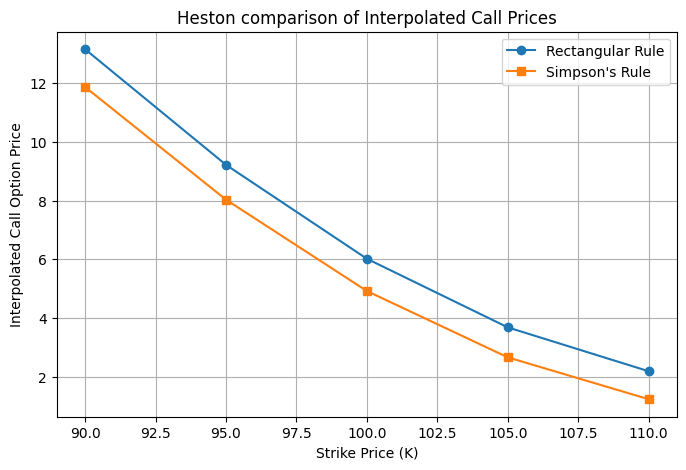

In [22]:
# Strike prices
K = np.array([90, 95, 100, 105, 110])

# Interpolated Call Option Prices
rectangular_prices = np.array([13.15635534, 9.21922733, 6.02001848, 3.68348957, 2.18923837])
simpsons_prices = np.array([11.86948409, 8.03260243, 4.92126852, 2.66227987, 1.23685927])

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(K, rectangular_prices, 'o-', label="Rectangular Rule", markersize=6)
plt.plot(K, simpsons_prices, 's-', label="Simpson's Rule", markersize=6)

# Labels and title
plt.xlabel("Strike Price (K)")
plt.ylabel("Interpolated Call Option Price")
plt.title("Heston comparison of Interpolated Call Prices")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
